-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [1]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

In [2]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [29]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.normal(0,1,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0,1,(self.N,1))
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [73]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (np.exp(2*self.sigma*x)-1)/(np.exp(2*self.sigma*x)+1)

    # forward propagation
    def predict(self, x, w, b, v):
        
        z = np.dot(w, x) - b
        a = self.g(z)
        self.output = np.dot(v, a)
        return self.output
    
    """
    there's a mistake here somewhere... 
    """
    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        
        dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        db1 = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        db =(1/self.X.shape[1]) *  np.sum(db1, axis = 1, keepdims = True)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        

        return np.concatenate([array.reshape(-1) for array in [dw, db, dv]])
        
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        
        """
        to use the manual gradient put jac = self.grad and check if train error is still 0.001392
        """

        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        self.w, self.b, self.v = self.separate(result.x)
        
        func_eval = result.nfev
        grad_eval = result.njev
        iterations = result.nit
        opt_fun = result.fun
        return func_eval, grad_eval, iterations, opt_fun, time_elapsed

## first run

In [75]:
nn = Mlp(X_train, y_train, N = 50, sigma = 5, rho = 10e-5, method = "BFGS")
func_eval, grad_eval, iterations, opt_fun, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))

begin training... 

      fun: 0.0038398163782748206
 hess_inv: array([[ 310.74122258,   48.47206043,  -39.74019717, ...,   54.83034901,
         -77.08886338,    5.95826928],
       [  48.47206043,  261.43799326,   10.63706296, ...,   16.42889434,
         -21.4175707 ,   26.13419888],
       [ -39.74019717,   10.63706296,  110.11035061, ...,  -25.16362571,
           3.98071749,   19.88905577],
       ...,
       [  54.83034901,   16.42889434,  -25.16362571, ...,  357.63338688,
        -228.3537954 ,   35.32170894],
       [ -77.08886338,  -21.4175707 ,    3.98071749, ..., -228.3537954 ,
         532.85622539, -172.55365382],
       [   5.95826928,   26.13419888,   19.88905577, ...,   35.32170894,
        -172.55365382,  448.04900006]])
      jac: array([ 1.08797995e-06, -1.31958447e-06,  9.14742776e-06, -5.48356016e-08,
        3.09614534e-06,  2.59605491e-06,  7.66157428e-07, -2.34970922e-06,
       -1.70459654e-06, -4.47974606e-07, -1.70141460e-07, -1.48962192e-06,
        4.02496

        4.01583369e-01,  3.08505309e-01, -3.98619855e-01, -3.44450145e-01])
finished training.
Training Error : 0.0005235192612390802


In [76]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(1, -1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    


In [ ]:
plot(nn)

In [239]:
#
# Grid Search (takes ~2 hours) -------> (50, 5, 0.0001, 'CG') error on val of ~0.00022
#

"""
param_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    print("current combination :", comb)
    print("\n")
    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))
"""

'\nparam_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}\n\nresults = []\ncombinations = list(itertools.product(*param_grid.values()))\nfor comb in tqdm_notebook(combinations):\n    \n    print("current combination :", comb)\n    print("\n")\n    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])\n    nn.optimize()\n    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))\n'

In [60]:
# trials for the graddient....
N = 20
w = np.random.uniform(0,1,(N, 2))
b = np.random.normal(0,1,(N, 1))
v = np.random.normal(0,1,(1, N))
# activation function
def g(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x)) 
def sech(x):
    return np.square(2/(np.exp(x) - np.exp(-x)))
    
a = np.dot(w, X_train) - b
z = g(a)
f_x = np.dot(v, z)
rho = 10e-5

dw = (1/X_train.shape[1]) * (v.T @ (f_x-y_train) * (1-np.square(g(a)))) @ X_train.T
#dw = 2*rho*np.sum(w) + (1/X_train.shape[1]) * np.dot(np.dot(v.T, f_x-y_train)* (1-np.square(g(a))), X_train.T)
dv = 2*rho*v + (1/X_train.shape[1]) * np.dot(f_x-y_train, g(a).T)
db = 2*rho*b + (1/X_train.shape[1]) * np.dot(v.T, f_x-y_train)* np.square(sech(a))
db = np.sum(db, axis = 1, keepdims = True)
#boh2 = 2*rho*v + np.mean((f_x - y_train) * g(a))

In [57]:
np.sum(b, axis = 1, keepdims = False)

array([-0.04379429, -0.59743679,  0.18805671,  0.68959919,  0.02345915,
        0.44106564, -0.96132751,  1.37605579, -0.72280091,  1.40807799,
        0.11061588, -1.08883494,  1.54692506,  1.13539294,  0.5477631 ,
       -0.13133071,  1.55658436, -0.87869502, -0.98529566,  1.16099742])

In [9]:
dw = np.zeros_like(w)
for j in range(N):
    for i in range(X_train.shape[0]):
        dw[j+1] = 2*rho*w[j+i] + 1/(X_train.shape[1])*np.sum((f_x - y_train)*np.sum(v*sech(np.sum()))*X_train[i,:])

ValueError: operands could not be broadcast together with shapes (1,20) (20,210) 

In [63]:
np.multiply((1/4), np.concatenate([array.reshape(-1) for array in [w, b, v]]))

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75])

In [19]:
2*rho*np.sum(w) + (1/X_train.shape[1]) * np.dot(np.dot(v.T, f_x-y_train)* (1-np.square(g(a))), X_train.T)

array([[-0.36416989,  0.32642425],
       [-0.04616261, -0.20215945],
       [-0.15864655,  0.26325293],
       [ 0.60101376, -0.51211595],
       [ 0.1338876 , -0.03095073],
       [-0.46385986,  1.00930537],
       [ 1.28953353, -0.87882896],
       [-0.55839382,  0.3873266 ],
       [ 0.16834935,  0.48005134],
       [ 0.00773789, -0.06199074],
       [-1.2615162 ,  0.81552151],
       [-1.43321644,  0.83663871],
       [-0.1553988 ,  0.05481721],
       [ 0.33063404, -0.4147983 ],
       [ 0.81149272, -0.33949117],
       [-0.22334479,  0.40873182],
       [-0.13268599, -0.20464219],
       [-1.12255175,  0.40842122],
       [-1.01868065,  0.43970415],
       [-0.63191294,  0.47555013]])

In [15]:
v = (y_train.dot(a.T.dot(a) + rho*np.identity(X_train.shape[1]))).dot(a.T)

In [109]:
np.dot(w, X_train)

array([[ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333],
       [ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333],
       [ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333],
       ...,
       [ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333],
       [ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333],
       [ 0.53277872, -2.39935881, -0.34530963, ..., -2.36901195,
         0.71807408,  0.31111333]])

In [115]:
np.concatenate((y_train, np.zeros(20)))

array([ 1.30859380e+00,  2.56154100e+00,  7.79290010e-01,  1.14841914e+00,
        2.10916347e+00,  2.89578397e+00, -3.27758446e-03,  2.42421913e+00,
        6.91687817e-01,  2.09507280e+00, -4.81234602e-01,  1.76638091e+00,
        4.36194418e-01,  1.91900767e+00,  2.33155807e+00,  2.68338499e-01,
       -7.38349856e-01,  3.09578433e+00,  2.60239393e-01,  1.68262452e+00,
        2.17437668e+00, -4.02127143e-01,  1.29418040e-01,  1.29847979e+00,
        1.24588148e+00,  4.02259673e-01,  2.40535396e+00,  4.72370948e+00,
        1.31003176e+00, -4.27831556e-01,  2.24280527e+00,  1.18329221e+00,
        2.12794540e+00,  2.11069093e+00,  1.38541858e+00, -8.92896333e-01,
        2.72092285e+00, -6.35756190e-03,  2.31350881e+00,  8.84595386e-01,
        5.82505414e-01,  1.51404648e+00,  1.40850994e+00,  2.41108402e+00,
        6.93412176e-01,  6.67446325e-01,  1.64918509e+00,  5.35551969e-01,
        2.17221095e+00,  6.43193105e-01,  3.62378234e+00,  3.66387571e-02,
        3.28705624e+00,  

------------------------------------

# Exercise 2.1

the error reduces to: $\underset{w_0, b_0, v}{min} \frac{1}{2P} (\sum_{p=1}^P v_j \sum_{i=1}^nw_{ij}x + b_j)- y^p)^2 + \rho||\mathbf{\omega}||^2 = ||\mathbf{v}(\mathbf{W}\mathbf{X} + \mathbf{b}) - \mathbf{Y}||^2 + \rho||\mathbf{v}||^2$



In [21]:
X_train, X_test, y_train, y_test = data_split(data, val = False)

In [103]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.uniform(-1,1,(self.N, self.X.shape[0]))
        self.b = np.random.uniform(-0.5,0.5,(self.N,1))
        self.v = np.random.uniform(-0.5,0.5,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) 
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

In [104]:
class Mlp_El(ShallowNeuralNetwork):

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))
    
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y))
    
    # to see why the mess here: https://stats.stackexchange.com/questions/69205/how-to-derive-the-ridge-regression-solution
    def optimize(self):
        
        a = self.w @ self.X - self.b
        H = self.g(a)
        H = np.concatenate((H.T, np.sqrt(self.rho)*np.identity(self.N))).T
        y = np.concatenate((self.y, np.zeros(self.N)))
        """
        clf = Ridge(alpha = self.rho, tol = 10e-8)
        print(H.shape, self.y.shape)
        clf.fit(H.T, self.y.T)
        self.v = clf.coef_
        """

        self.v =  np.linalg.inv(H @ H.T) @ H @ y # equal to self.v = y @ np.linalg.pinv(H) (moore-penrose pseudo inverse)
        
            
    # forward propagation
    def predict(self, x, w, b, v):
        
        a = w @ x - b
        z = self.g(a)
        self.output = v @ z
        return self.output

In [117]:
while nn.mse(X_test, y_test, nn.w, nn.b, nn.v) > 0.03 or nn.mse(X_train, y_train, nn.w, nn.b, nn.v) > 0.02:
    nn = Mlp_El(X_train, y_train, N = 50, sigma = 5, rho = 10e-5)
    nn.optimize()
    
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

Train Error : 0.019268409014467025
Test Error : 0.028417998828430102


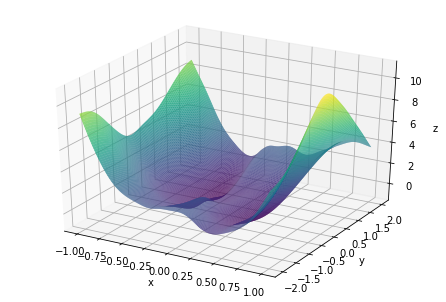

In [116]:
plot(nn)

In [25]:
np.gradient(nn.v)

array([ 0.37452956,  1.0744571 ,  0.20314736, -0.89190109, -0.56477602,
       -0.39984677,  0.51577949,  0.57347426, -0.82860887, -0.88801267,
       -1.65584355,  1.45237854,  2.67344526, -0.04384164,  0.13858488,
       -0.98267368, -0.72427682,  0.97595241,  1.28792587, -0.27831438,
       -0.92336458, -0.48906938,  0.76120832, -0.7600043 , -0.39389544,
        0.86010032, -0.76394562,  0.51041859, -0.56316549, -0.08825508,
       -0.14935362, -0.19680462,  0.81565984, -1.29890952, -0.15784029,
        1.07501621,  0.02753979,  0.02672417, -1.04473657,  0.1023463 ,
        1.29554037, -0.3824138 , -0.17006907,  0.07268888,  0.36240618,
        1.77705506, -0.05482152, -2.38885291,  0.10263784,  1.92946107])

----------------
## non exact el solution

In [94]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp_nonexact(ShallowNeuralNetwork):
    
    def loss(self,params):

        v = params
        return 0.5 * np.mean(np.square((self.predict(self.X, self.w, self.b, v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(params))

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (np.exp(-2*x*self.sigma)-1)/(np.exp(-2*x*self.sigma)+1)

    # forward propagation
    def predict(self, x, w, b, v):
        
        a = np.dot(w, x) - b
        z = self.g(a)
        self.output = np.dot(v, z)
        return self.output
    
    def grad(self, v):        
        a = self.w @ self.X - self.b
        G = self.g(a)
        Q = G @ G.T + self.rho*np.identity(self.N)
        print((G @ self.y).shape)
        dv = 2*(Q @ v) - 2*(G @ self.y) 
        return dv
    
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = self.v
        print("begin training...", "\n")
        start = time.time()
 
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        self.v = result.x
        
        func_eval = result.nfev
        grad_eval = result.njev
        iterations = result.nit
        opt_fun = result.fun
        return func_eval, grad_eval, iterations, opt_fun, time_elapsed

In [95]:
nn = Mlp_nonexact(X_train, y_train, N = 50, sigma = 5, rho = 10e-5, method = "CG")
nn.optimize()
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

begin training... 

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(5

KeyboardInterrupt: 

In [85]:
np.linalg.norm(np.gradient(nn.v))

4.5655811554480925

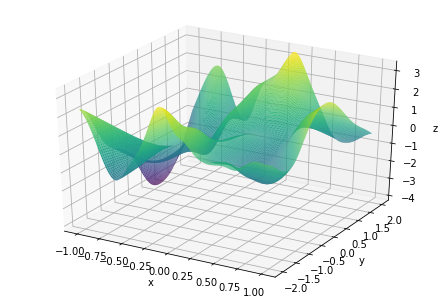

In [550]:
plot(nn)